# Phase 3 (self directed)
## Light GBM & Full Feature Set Experimentation
By Harold Davies

This notebook was created using "SK8_Light_GBM.ipynb" from Dr. Akman's github: https://github.com/akmand/ml_tutorials.

In [1]:
#This notebook was adapted from "SK8_Light_GBM.ipynb" from Dr. Akman's github: https://github.com/akmand/ml_tutorials

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_raw = pd.read_csv('clean_data.csv')
df_raw = df_raw.rename(columns={'churn': 'target'})

In [3]:
df = df_raw.copy()
df.head()

,account_age,intl_plan,voice_mail_plan,n_voice_mails,n_day_calls,sum_day_charges,n_evening_calls,sum_evening_charges,n_night_calls,sum_night_charges,n_intl_calls,sum_intl_charges,n_customer_service_calls,target
0,128,0,1,25.00,110.00,45.07,99.00,16.78,91.00,11.01,3.00,2.70,1.00,0
1,107,0,1,26.00,123.00,27.47,103.00,16.62,103.00,11.45,3.00,3.70,1.00,0
2,137,0,0,0.00,114.00,41.38,110.00,10.30,104.00,7.32,5.00,3.29,0.00,0
3,84,1,0,0.00,71.00,50.90,88.00,5.26,89.00,8.86,7.00,1.78,2.00,0
4,75,1,0,0.00,113.00,28.34,122.00,12.61,121.00,8.41,3.00,2.73,3.00,0


### Optional Feature Selection

In [4]:
columns_to_keep = ['sum_day_charges', 'n_customer_service_calls',
       'sum_evening_charges', 'intl_plan', 'sum_intl_charges',
       'n_intl_calls']

In [5]:
Data = df.drop(columns = 'target').copy()
target = np.array(df['target']).reshape(-1, 1)

In [6]:
Data.dtypes

account_age                   int64
intl_plan                     int64
voice_mail_plan               int64
n_voice_mails               float64
n_day_calls                 float64
sum_day_charges             float64
n_evening_calls             float64
sum_evening_charges         float64
n_night_calls               float64
sum_night_charges           float64
n_intl_calls                float64
sum_intl_charges            float64
n_customer_service_calls    float64
dtype: object

### Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

Data_train, Data_test, t_train, t_test = train_test_split(Data, 
                                                    target, 
                                                    test_size = 0.3, 
                                                    stratify=target,
                                                    random_state=99)
print(f"Data.shape: {Data.shape}")
print(f"Data_train.shape: {Data_train.shape}")
print(f"Data_test.shape: {Data_test.shape}")

Data.shape: (3315, 13)
Data_train.shape: (2320, 13)
Data_test.shape: (995, 13)


### Utility Function for Printing Results

In [8]:
from sklearn import metrics

def print_stats(clf, clf_name, Data_test, t_test, pr_threshold=0.5):
    #
    t_pred = (clf.predict_proba(Data_test)[:,1] >= pr_threshold).astype(int)
    #
    print(f"classifier: {clf_name}")
    print(f"pr_threshold: {pr_threshold}")
    print(f"accuracy : {metrics.accuracy_score(t_test, t_pred):.2f}")
    print(f"recall   : {metrics.recall_score(t_test, t_pred):.2f}")
    print(f"precision: {metrics.precision_score(t_test, t_pred):.2f}")
    print(f"f1-score : {metrics.f1_score(t_test, t_pred):.2f}")
    #
    # must pass in the proba's to roc_auc_score(), not the predictions!
    t_prob = clf.predict_proba(Data_test)
    print(f"roc-auc  : {metrics.roc_auc_score(t_test, t_prob[:,1]):.2f}")
    print("-----------")
    print("confusion matrix:")
    print(metrics.confusion_matrix(t_test, t_pred))

### Fitting LGBM with Defaults Modified

In [9]:
%%time

import lightgbm as lgbm

clf_name = 'Light GBM'

lgbm_params_fixed = {"objective": "binary",                      
                     "max_bin": 100, 
                     "min_data_in_bin": 10,
                     "is_unbalance": True}

clf = lgbm.LGBMClassifier(**lgbm_params_fixed)

clf.fit(Data_train, t_train);

clf_feat_select = lgbm.LGBMClassifier(**lgbm_params_fixed)

clf_feat_select.fit(Data_train[columns_to_keep], t_train);

[LightGBM] [Info] Number of positive: 334, number of negative: 1986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 2320, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143966 -> initscore=-1.782737
[LightGBM] [Info] Start training from score -1.782737
[LightGBM] [Info] Number of positive: 334, number of negative: 1986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 2320, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143966 -> initscore=-1.782737
[LightGBM] [I

LGBMClassifier(is_unbalance=True, max_bin=100, min_data_in_bin=10,
               objective='binary')

### (Untuned) Model Performance on Train Data

In [10]:
pr_threshold = 0.5
print("Performance on Train Data")
print_stats(clf, clf_name, Data_train, t_train, pr_threshold=pr_threshold)

Performance on Train Data
classifier: Light GBM
pr_threshold: 0.5
accuracy : 1.00
recall   : 1.00
precision: 1.00
f1-score : 1.00
roc-auc  : 1.00
-----------
confusion matrix:
[[1986    0]
 [   0  334]]


In [11]:
pr_threshold = 0.5
print("Performance on Train Data with Feature Selection")
print_stats(clf_feat_select, clf_name, Data_train[columns_to_keep], t_train, pr_threshold=pr_threshold)

Performance on Train Data with Feature Selection
classifier: Light GBM
pr_threshold: 0.5
accuracy : 0.99
recall   : 1.00
precision: 0.96
f1-score : 0.98
roc-auc  : 1.00
-----------
confusion matrix:
[[1971   15]
 [   0  334]]


### (Untuned) Model Performance on Test Data

In [12]:
pr_threshold = 0.5
print("Performance on Test Data")
print_stats(clf, clf_name, Data_test, t_test, pr_threshold=pr_threshold)

Performance on Test Data
classifier: Light GBM
pr_threshold: 0.5
accuracy : 0.95
recall   : 0.78
precision: 0.85
f1-score : 0.81
roc-auc  : 0.89
-----------
confusion matrix:
[[832  20]
 [ 32 111]]


In [13]:
pr_threshold = 0.5
print("Performance on Test Data with Feature Selection")
print_stats(clf_feat_select, clf_name, Data_test[columns_to_keep], t_test, pr_threshold=pr_threshold)

Performance on Test Data with Feature Selection
classifier: Light GBM
pr_threshold: 0.5
accuracy : 0.92
recall   : 0.69
precision: 0.73
f1-score : 0.71
roc-auc  : 0.86
-----------
confusion matrix:
[[816  36]
 [ 44  99]]


## Hyper-parameter Tuning with Optuna <a id='optuna'></a>

### Defining the Grid and Objective Function
We first define an objective function with **cross-validated** log loss as our performance metric for guiding the tuning process. The `LightGBMPruningCallback()` below from Optuna's integration module identifies unpromising hyper-parameter sets beforehand and reduces the search time significantly.

In [14]:
# ! pip install optuna
# ! pip install optuna-integration

import optuna  
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback

NUM_CV_FOLDS = 10
EVAL_METRIC = "binary_logloss"

def objective_fn(trial, Data, target, lgbm_params_fixed):
    
    grid_params = {
    "num_iterations": trial.suggest_int("num_iterations", 50, 80, step=10),
    "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 10, 40, step=2),
    "min_child_samples": trial.suggest_int("min_child_samples", 10, 50, step=5),
    }
    
    cv = StratifiedKFold(n_splits=NUM_CV_FOLDS, 
                         shuffle=True, 
                         random_state=999)
    
    cv_scores = np.empty(NUM_CV_FOLDS)
    
    for idx, (train_idx, valid_idx) in enumerate(cv.split(Data, target)):
        
        Data_train, Data_valid = Data.iloc[train_idx], Data.iloc[valid_idx]
        t_train, t_valid = target[train_idx], target[valid_idx]

        model = lgbm.LGBMClassifier(**lgbm_params_fixed, **grid_params)
        
        model.fit(
            Data_train,
            t_train,
            eval_set=[(Data_valid, t_valid)],
            eval_metric=EVAL_METRIC,
            callbacks=[LightGBMPruningCallback(trial, EVAL_METRIC)],
        )
        
        t_pred = model.predict_proba(Data_valid)
        cv_scores[idx] = log_loss(t_valid, t_pred)

    return np.mean(cv_scores)

In [15]:
# tuning with TPE

optuna_study = optuna.create_study(direction="minimize", 
                                   sampler=optuna.samplers.TPESampler(), # default sampler is TPE
                                   # sampler=optuna.samplers.RandomSampler(seed=999), # random sampler can also be used                                  
                                   study_name="Light GBM Tuning with TPE")

[I 2024-06-24 03:14:19,218] A new study created in memory with name: Light GBM Tuning with TPE


### Running the Tuner

In [16]:
TIME_LIMIT = 30  # in seconds
NUM_JOBS_TUNING = 3 # for parallel processing

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [17]:
%%time

optuna_trial = lambda trial: objective_fn(trial, 
                                         Data_train, 
                                         t_train, 
                                         lgbm_params_fixed)

optuna_study.optimize(optuna_trial,
                      timeout=TIME_LIMIT,
                      n_jobs=NUM_JOBS_TUNING)

CPU times: total: 3min 48s
Wall time: 31.7 s


In [18]:
print(f"Best objective function value: {optuna_study.best_value:.5f}")
optuna_study.best_params

Best objective function value: 0.16780


{'num_iterations': 80,
 'learning_rate': 0.1417387357183339,
 'num_leaves': 22,
 'min_child_samples': 10}

### Viewing the results

In [19]:
df_tuning_results = optuna_study.trials_dataframe().sort_values(by=['value'])
print(df_tuning_results.shape)
df_tuning_results.head(5)

(105, 10)


,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_min_child_samples,params_num_iterations,params_num_leaves,state
103,103,0.14,2024-06-24 03:14:47.544161,2024-06-24 03:14:47.786473,0 days 00:00:00.242312,0.26,10,50,26,PRUNED
70,70,0.15,2024-06-24 03:14:40.270918,2024-06-24 03:14:40.649443,0 days 00:00:00.378525,0.27,30,70,38,PRUNED
9,9,0.15,2024-06-24 03:14:23.159843,2024-06-24 03:14:23.378659,0 days 00:00:00.218816,0.22,25,70,20,PRUNED
8,8,0.15,2024-06-24 03:14:22.791317,2024-06-24 03:14:23.157819,0 days 00:00:00.366502,0.11,20,80,22,PRUNED
71,71,0.16,2024-06-24 03:14:40.290686,2024-06-24 03:14:40.593186,0 days 00:00:00.302500,0.27,40,60,38,PRUNED


### Optimisation Hot Start

In [20]:
%%time

# second round of optimisation
optuna_study.optimize(optuna_trial, 
                      timeout=TIME_LIMIT,
                      n_jobs=NUM_JOBS_TUNING)

CPU times: total: 3min 51s
Wall time: 31 s


In [21]:
print(f"Second round best objective function value: {optuna_study.best_value:.5f}")

optuna_study.best_params

Second round best objective function value: 0.16780


{'num_iterations': 80,
 'learning_rate': 0.1417387357183339,
 'num_leaves': 22,
 'min_child_samples': 10}

## Evaluation & Visualisation of Results <a id='vis'></a>

### Evaluation of the Model with Tuned Parameters

In [22]:
clf_name = 'Light GBM'

lgbm_params_tuned = optuna_study.best_params

clf_tuned = lgbm.LGBMClassifier(**lgbm_params_fixed, **lgbm_params_tuned)

clf_tuned.fit(Data_train, t_train);

[LightGBM] [Info] Number of positive: 334, number of negative: 1986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 2320, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143966 -> initscore=-1.782737
[LightGBM] [Info] Start training from score -1.782737


### Tuned Model Performance on Train Data

In [23]:
pr_threshold = 0.5
print("Performance on Train Data")
print_stats(clf_tuned, clf_name, Data_train, t_train, pr_threshold=pr_threshold)

Performance on Train Data
classifier: Light GBM
pr_threshold: 0.5
accuracy : 1.00
recall   : 1.00
precision: 1.00
f1-score : 1.00
roc-auc  : 1.00
-----------
confusion matrix:
[[1986    0]
 [   0  334]]


### Tuned Model Performance on Test Data

In [24]:
pr_threshold = 0.5
print("Performance on Test Data")
print_stats(clf_tuned, clf_name, Data_test, t_test, pr_threshold=pr_threshold)

Performance on Test Data
classifier: Light GBM
pr_threshold: 0.5
accuracy : 0.95
recall   : 0.79
precision: 0.87
f1-score : 0.83
roc-auc  : 0.89
-----------
confusion matrix:
[[835  17]
 [ 30 113]]


### Visualisation of Model Feature Importances

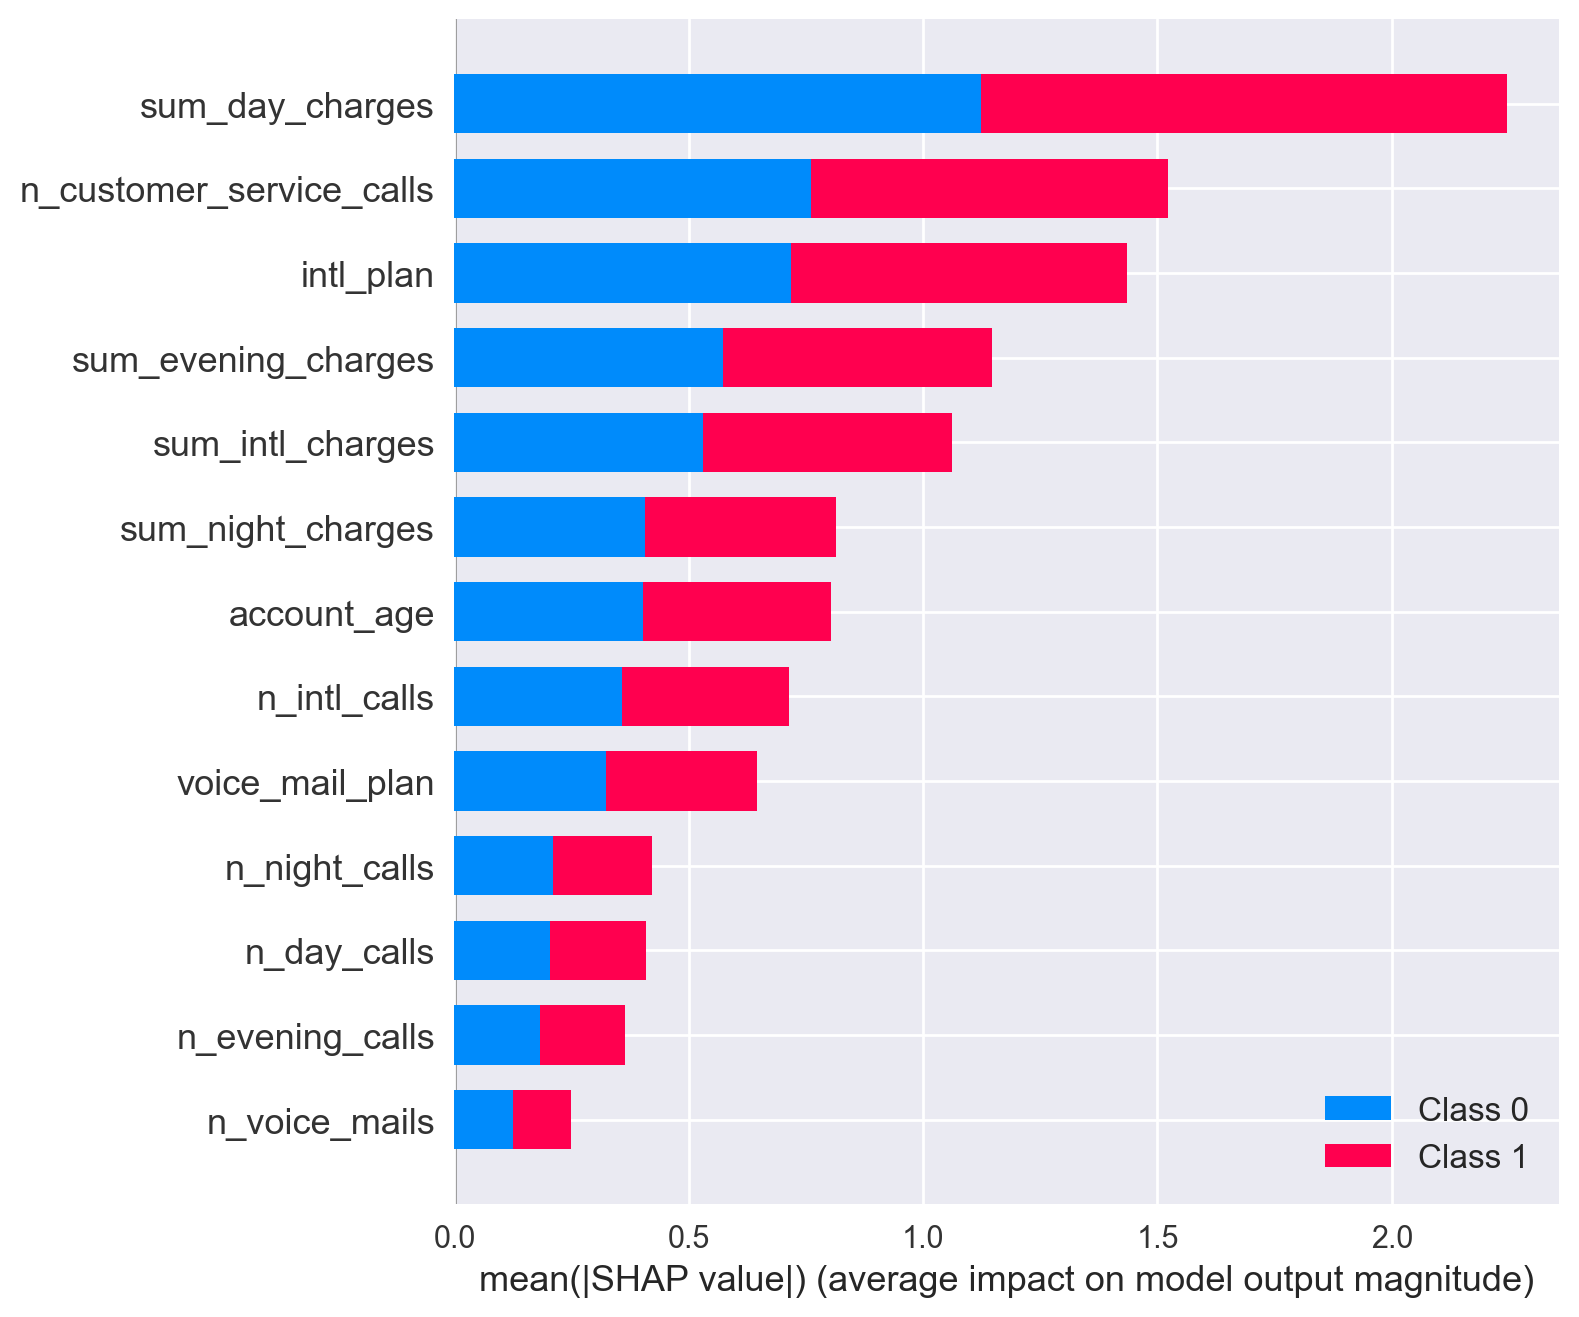

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.style.use("seaborn")

plt.rcParams["figure.figsize"] = (10,6)

explainer = shap.TreeExplainer(clf) 
shap_values = explainer.shap_values(Data_train) 
shap.summary_plot(shap_values, Data_train) 

### Visualisation of Tuning Progress

In [26]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(optuna_study)

### Visualisation of Hyper-parameter Importances

In [27]:
from optuna.visualization import plot_param_importances

plot_param_importances(optuna_study)

### Discussion of Results

In the prior phase of this project, the highest performing model for churn prediction was a random forest with an AUC score of 0.77. Using the same train test split on the same data, the Light GBM (L-GBM) has achieved a maximum of 0.89, outperforming the random forest by a significant margin of 12%. It is also evident that the L-GBM benefits significantly from having all available features, with the untuned model outperforming across the board, but importantly specifically with respect to recall and AUC, when it had all the features compared with the 6 features selected in phase 2 of the project using Random Forest Importance. It can be concluded that the 7 features excluded through the feature selection process contain meaningful information which is useful for a model as complex as a L-GBM in differentiating churners from non-churners. Likewise, it can also be concluded that the data purtaining to telecommunication customers has very complex and meaningful relationships between the descriptive features and target feature, which has resulted in a sophisticated, boosted ensemble model meaningfully outperforming the more simple random forest ensemble model tested in phase 2 of the project. 